In [206]:
import csv
import random
import numpy as np
def load_data(path):
    a = []
    with open(path, 'r', encoding='utf-8') as f: 
        rdr = csv.reader(f)
        for i in rdr:
            i = list(map(int,i))
            a.append(i)
    return a
def split_list(l, trunc_size=200):
    if len(l)<=trunc_size:
        return [l]
    result = []
    n = (len(l)-1)//trunc_size + 1
    for i in range(n):
        result.append(l[i*trunc_size:(i+1)*trunc_size])
    return result
def truncate(data):
    #If len>200, split
    result = []
    for line in data:
        for i in split_list(line):
            result.append(i)
            
    return result
train_q = load_data("./dataset/train_q.csv")
train_a = load_data("./dataset/train_a.csv")
test_q = load_data("./dataset/test_q.csv")
test_a = load_data("./dataset/test_a.csv")

train_q = truncate(train_q)
train_a = truncate(train_a)
test_q = truncate(test_q)
test_a = truncate(test_a)



def shuffle_list(q,a, tolist=True):
    tmp = list(zip(q,a))
    random.shuffle(tmp)
    q,a = zip(*tmp)
    if tolist==False:
        return [np.array(q), np.array(a)]
    return [list(q),list(a)]

train_q, train_a = shuffle_list(train_q, train_a)
test_q, test_a = shuffle_list(test_q, test_a)

print("Max exercise tag :",max(map(max,train_q)), "Min exercise tag :",min(map(min,train_q)))
val_q = train_q[3800:]
val_a = train_a[3800:]
train_q = train_q[:3800]
train_a = train_a[:3800]
train_q.sort(key=len)
train_a.sort(key=len)
val_q.sort(key=len)
val_a.sort(key=len)
test_q.sort(key=len)
test_a.sort(key=len)

def more_than_two(l):
    for idx in range(len(l)):
        if len(l[idx])>=2:
            break
    return l[idx:]
train_q = more_than_two(train_q)
train_a = more_than_two(train_a)
val_q = more_than_two(val_q)
val_a = more_than_two(val_a)
test_q = more_than_two(test_q)
test_a = more_than_two(test_a)

print("len(train) :", len(train_q), "len(val) :", len(val_q), "len(test) :", len(test_q))
print("Train max_timeSteps :", max([len(i) for i in train_q]), 
      "Validation max_timeSteps :", max([len(i) for i in val_q]), 
      "Test max_timeSteps :", max([len(i) for i in test_q]), )


Max exercise tag : 123 Min exercise tag : 0
len(train) : 3724 len(val) : 821 len(test) : 1215
Train max_timeSteps : 200 Validation max_timeSteps : 200 Test max_timeSteps : 200


In [231]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tag_num = 125#124 + 1(zero padding)
N = tag_num*2#number of tags x 2
padding_value = -1
batch_size = 256
hidden_size = 200
dropout_rate=0.4
def make_batch(data):
    #Dividing, zero padding
    #Exercise tag : 1~124
    #Answer = 1 | 2
    result = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        padded_batch = keras.preprocessing.sequence.pad_sequences(batch, 
                                                                  padding="post", value=padding_value)
        result.append(padded_batch+1)
    return result

def encoding(q,a):
    

    encoding = np.eye(tag_num)
    x=encoding[q]
    x = np.concatenate((x,x*np.expand_dims(a//2, axis=-1)), axis=-1)
        
    return x


In [232]:
class Model(layers.Layer):
    def __init__(self, **kwargs):
        super(Model, self).__init__(**kwargs)
        self.embedding = layers.Embedding(input_dim=N, output_dim=N, mask_zero=True)
        self.lstm = layers.LSTM(hidden_size, return_sequences=True)
        self.dropout = layers.Dropout(dropout_rate)
        self.dense = layers.Dense(tag_num, activation='sigmoid')
        
    def call(self, q,a, training=False):
        inputs = encoding(q,a)
        mask = self.embedding.compute_mask(q)
        output = self.lstm(inputs, mask=mask, training=training)
        output = self.dropout(output, training=training)
        output = self.dense(output,training=training)
        
        return output
def loss_acc(y,q,a):
    en = encoding(q,a)
    q = en[:,:,:tag_num]
    a = en[:,:,tag_num:]
    #y.shape = q.shape = a.shape = [batch_size, timesteps, tag_num]
    #Loss = binary_cross_entropy(yT * qT+1, aT+1)
    y_cropped = y[:, :-1, :]#y1...yT-1
    q_cropped = q[:, 1:, :]#q2...qT
    a_cropped = a[:, 1:, :]#a2...aT
    
    acc1 = y_cropped*q_cropped>0.5
    acc2 = a_cropped
    y_summed = tf.cast(tf.reduce_sum(y_cropped*q_cropped, axis=-1), dtype=tf.double)
    a_summed = tf.cast(tf.reduce_sum(a_cropped, axis=-1), dtype=tf.double)
    l=-a_summed * tf.math.log(y_summed+1e-07)-(1-a_summed)*tf.math.log(1-y_summed+1e-07)
  
    threshold = 0.5
    
    
    m = tf.keras.metrics.AUC()
    m.update_state(y_summed>threshold, a_summed)
    auc = m.result()
    #print(acc1[0])
    return (tf.reduce_mean(l), auc)

layer = Model()
train_q_batches = make_batch(train_q)
train_a_batches = make_batch(train_a)
val_q_batches = make_batch(val_q)
val_a_batches = make_batch(val_a)
test_q_batches = make_batch(test_q)
test_a_batches = make_batch(test_a)



In [233]:
import os
epoch_num = 300
initial_lr = 0.1
learning_rate = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=initial_lr, decay_steps=3000, decay_rate=0.96, staircase=True)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=20.0, epsilon=0.1)

loss_train_list = []
auc_train_list = []
loss_val_list = []
auc_val_list = []
max_auc = 0.8
best_epoch = 0
for epoch in range(epoch_num):
    loss_train = 0
    auc_train = 0
    train_q_batches, train_a_batches = shuffle_list(train_q_batches, train_a_batches)
    for q,a in zip(train_q_batches, train_a_batches):
        
        with tf.GradientTape() as tape:
            logit = layer.call(q,a, training=True)
            
            loss_batch, auc_batch = loss_acc(logit, q,a)
        grad = tape.gradient(loss_batch, layer.trainable_variables)
        
        optimizer.apply_gradients(grads_and_vars=zip(grad, layer.trainable_variables))
        
        loss_train += loss_batch.numpy()/len(train_q_batches)
       
        auc_train += auc_batch.numpy()/len(train_q_batches)
        
    
    print("Epoch :", epoch, "Train      loss :",loss_train, "AUC :", auc_train)
    loss_train_list.append(loss_train)
    auc_train_list.append(auc_train)
    
    loss_val = 0
    auc_val = 0
    for q_val, a_val in zip(val_q_batches, val_a_batches):
        logit_val = layer.call(q_val, a_val)
        loss_batch_val, auc_batch_val = loss_acc(logit_val, q_val, a_val)
        loss_val += loss_batch_val.numpy()/len(val_q_batches)
        auc_val += auc_batch_val.numpy()/len(val_q_batches)
        
    
    print("Validation     loss :", loss_val, "AUC :", auc_val)
    loss_val_list.append(loss_val)
    auc_val_list.append(auc_val)
    if auc_val > max_auc:
        max_auc = auc_val
        best_epoch = epoch
        root = tf.train.Checkpoint(optimizer=optimizer,
                           model=layer)
        checkpoint_dir = './ckpt_'+ str(auc_val*1000)[:3] + "_" + str(epoch)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        root.save(checkpoint_prefix)
        print("---------------------saved--------------------")
        
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch : 0 Train      loss : 0.6860496099776627 AUC : 0.5927751421928406
Validation     loss : 0.6733153321329266 AUC : 0.6592308133840561
Epoch : 1 Train      loss : 0.6727924116676225 AUC : 0.6333408832550049
Validation     loss : 0.6482345534871163 AUC : 0.696875125169754
Epoch : 2 Train      loss : 0.6559114420858172 AUC : 0.6607084830602011
Validation     loss : 0.62243802864845 AUC : 0.7079610377550125
Epoch : 3 Train      loss : 0.6390820559336796 AUC : 0.6793463349342347
Validation     loss : 0.5

Epoch : 54 Train      loss : 0.46293823457616107 AUC : 0.7709153970082601
Validation     loss : 0.37025777416437755 AUC : 0.787147581577301
Epoch : 55 Train      loss : 0.4621316971396654 AUC : 0.772428031762441
Validation     loss : 0.36921604858882284 AUC : 0.7844553589820862
Epoch : 56 Train      loss : 0.46111613038306537 AUC : 0.7724135915438334
Validation     loss : 0.37361742996954295 AUC : 0.7751290798187256
Epoch : 57 Train      loss : 0.46101634504534345 AUC : 0.7726358771324157
Validation     loss : 0.3689377903025847 AUC : 0.78433957695961
Epoch : 58 Train      loss : 0.45927930772857445 AUC : 0.7724591533342997
Validation     loss : 0.3674445445149253 AUC : 0.7870320230722427
Epoch : 59 Train      loss : 0.4590092603525777 AUC : 0.7744342207908631
Validation     loss : 0.37025358237477146 AUC : 0.7800464928150177
Epoch : 60 Train      loss : 0.4599259696577302 AUC : 0.7757877190907795
Validation     loss : 0.36871202111642076 AUC : 0.7832355797290802
Epoch : 61 Train      

Epoch : 112 Train      loss : 0.4363680997727907 AUC : 0.7836678504943848
Validation     loss : 0.3499713946263666 AUC : 0.7975707799196243
Epoch : 113 Train      loss : 0.43534412463558136 AUC : 0.7844645102818806
Validation     loss : 0.3497120653775629 AUC : 0.8006014078855515
Epoch : 114 Train      loss : 0.4353859698952097 AUC : 0.7847859700520833
Validation     loss : 0.349592559834518 AUC : 0.7991063147783279
Epoch : 115 Train      loss : 0.4350266529452866 AUC : 0.7843913555145262
Validation     loss : 0.3493861989641556 AUC : 0.8001220375299454
Epoch : 116 Train      loss : 0.4346851309189509 AUC : 0.7841803312301636
Validation     loss : 0.3493130446058662 AUC : 0.799480751156807
Epoch : 117 Train      loss : 0.4345627505439845 AUC : 0.7841788649559023
Validation     loss : 0.3495707632995644 AUC : 0.7970443665981293
Epoch : 118 Train      loss : 0.43491342723998844 AUC : 0.7852106968561807
Validation     loss : 0.35054039107274215 AUC : 0.7918578833341599
Epoch : 119 Train  

Validation     loss : 0.3446506592249058 AUC : 0.8018522709608078
Epoch : 170 Train      loss : 0.4257755576313103 AUC : 0.7884593407313029
Validation     loss : 0.34410911864991134 AUC : 0.8011561036109924
Epoch : 171 Train      loss : 0.4254994878435883 AUC : 0.789274752140045
Validation     loss : 0.3435985172791654 AUC : 0.8031279593706131
Epoch : 172 Train      loss : 0.42472514334939954 AUC : 0.7886691093444824
Validation     loss : 0.343423218880123 AUC : 0.8030894696712494
Epoch : 173 Train      loss : 0.425193860226866 AUC : 0.7882925828297932
Validation     loss : 0.3434330288955204 AUC : 0.8012236058712006
Epoch : 174 Train      loss : 0.425370823555619 AUC : 0.7868999799092609
Validation     loss : 0.3436916797681831 AUC : 0.8062853217124939
Epoch : 175 Train      loss : 0.4266507156039046 AUC : 0.7878207365671793
Validation     loss : 0.3452463790536958 AUC : 0.8041252940893173
Epoch : 176 Train      loss : 0.4262038430684975 AUC : 0.7901382088661194
Validation     loss : 

Epoch : 227 Train      loss : 0.4192321927305064 AUC : 0.7923433939615885
Validation     loss : 0.34095966401806593 AUC : 0.8020363599061966
Epoch : 228 Train      loss : 0.4188229850531013 AUC : 0.7917260448137918
Validation     loss : 0.34182596508788293 AUC : 0.8025823533535004
Epoch : 229 Train      loss : 0.4187110755165977 AUC : 0.791830571492513
Validation     loss : 0.3413208361065663 AUC : 0.8076839447021484
Epoch : 230 Train      loss : 0.41894866705429096 AUC : 0.7917407472928365
Validation     loss : 0.3410722321092914 AUC : 0.8066537827253342
Epoch : 231 Train      loss : 0.4187973785444517 AUC : 0.7915300130844116
Validation     loss : 0.34063585673783736 AUC : 0.8045081794261932
Epoch : 232 Train      loss : 0.41832032375511524 AUC : 0.792275051275889
Validation     loss : 0.3412312276141827 AUC : 0.8016869574785233
Epoch : 233 Train      loss : 0.4179576933209997 AUC : 0.7931428750356039
Validation     loss : 0.3403711711572006 AUC : 0.8063953816890717
Epoch : 234 Train

Validation     loss : 0.3410150758788893 AUC : 0.8105081915855408
Epoch : 286 Train      loss : 0.413842964542659 AUC : 0.7954489707946778
Validation     loss : 0.3397961749835994 AUC : 0.803643062710762
Epoch : 287 Train      loss : 0.4137016197242487 AUC : 0.7940648516019184
Validation     loss : 0.34059965012387733 AUC : 0.8097044378519058
Epoch : 288 Train      loss : 0.41337139181919075 AUC : 0.7941858212153118
Validation     loss : 0.33982443369791715 AUC : 0.8054544627666473
Epoch : 289 Train      loss : 0.41331213445814274 AUC : 0.7961366295814515
Validation     loss : 0.3400647900904057 AUC : 0.8025496453046799
Epoch : 290 Train      loss : 0.41448666467846984 AUC : 0.7947105725606283
Validation     loss : 0.3401615845890281 AUC : 0.805616170167923
Epoch : 291 Train      loss : 0.41373473659438886 AUC : 0.7945653398831686
Validation     loss : 0.3401273190411197 AUC : 0.8029045313596725
Epoch : 292 Train      loss : 0.4139274906610142 AUC : 0.7940112551053365
Validation     lo

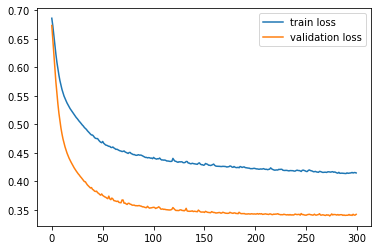

In [234]:
import matplotlib.pyplot as plt
plt.plot(loss_train_list, label='train loss')
plt.plot(loss_val_list, label='validation loss')
plt.legend()
plt.show()

MAX VAL AUC : 0.8111095279455185 epoch :  299


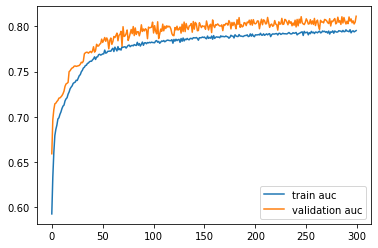

In [235]:
print("MAX VAL AUC :", max(auc_val_list), "epoch : ", auc_val_list.index(max(auc_val_list)))
plt.plot(auc_train_list, label='train auc')
plt.plot(auc_val_list, label='validation auc')
plt.legend()
plt.show()

In [236]:
loss_test = 0
auc_test = 0
root.restore(tf.train.latest_checkpoint('./ckpt_811_299'))
for i in range(len(test_q_batches)):
    test_q_batches[i], test_a_batches[i] = shuffle_list(test_q_batches[i], test_a_batches[i], tolist=False)

for q_test, a_test in zip(test_q_batches, test_a_batches):
    logit_test = layer.call(q_test, a_test)
    loss_batch_test, auc_batch_test = loss_acc(logit_test, q_test, a_test)
    loss_test += loss_batch_test.numpy()/len(test_q_batches)
    auc_test += auc_batch_test.numpy()/len(test_q_batches)

print("Test     loss :", loss_test, "AUC :", auc_test)
   

Test     loss : 0.34348594686851974 AUC : 0.8217064380645751
